In [3]:
import math
import pickle
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec

from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

In [4]:
# Read the file in which the values are saved
appa2 = pd.read_csv("../../exports/appa2_shrinked.csv")
appa2 = appa2.drop('Unnamed: 0', axis=1)

In [5]:
#selecting all the values we need to train and test the model
appa2 = appa2[[
    'LaFeO3_1', 'LaFeO3_2', 
    'STN_1', 'STN_2', 
    'LaFeO3_1_heatR', 'LaFeO3_2_heatR',
    'STN_1_heatR', 'STN_2_heatR', 
    "LaFeO3_1_Age", "LaFeO3_2_Age",
    "STN_1_Age","STN_2_Age",
    'Temperature', 'Relative_Humidity', 'Pressure', 'VOC', 
    'Wind_Speed', 
    'PM10', 'CO', 'NO2'
]]

# Random Forest

In [6]:
# Select the features
cols = [
    'LaFeO3_1', 'LaFeO3_2', 
    'STN_1', 'STN_2', 
    'LaFeO3_1_heatR', 'LaFeO3_2_heatR',
    'STN_1_heatR', 'STN_2_heatR', 
    "LaFeO3_1_Age", "LaFeO3_2_Age",
    "STN_1_Age","STN_2_Age",
    'Temperature', 'Relative_Humidity', 'Pressure', 'VOC', 
    'Wind_Speed'
]

# Select the target
outs = ['PM10', 'CO', 'NO2']

In [6]:
# # Split the values in training and test
# vsplit = round(len(appa2) * 0.2)

# X_train = appa2.iloc[vsplit:][cols]
# X_test = appa2.iloc[:vsplit][cols]

# Y_train = appa2.iloc[vsplit:][outs]
# Y_test = appa2.iloc[:vsplit][outs]

In [7]:
features = appa2[cols]
target= appa2[outs]

X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2, random_state=42, shuffle = False)

In [120]:
working_X_train, working_X_test, working_Y_train, working_Y_test = X_train, X_test, Y_train, Y_test

In [19]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start= 1000, stop= 2000, num=10)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [4, 5, 6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3, 6]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [1000, 1111, 1222, 1333, 1444, 1555, 1666, 1777, 1888, 2000], 'max_features': ['sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [4, 5, 6], 'min_samples_leaf': [2, 3, 6], 'bootstrap': [True, False]}


In [20]:
# Choose the type of model
model = RandomForestRegressor()

In [21]:
# Perform the RandomForestRegression with a Random Search on hyperparameters
rf_random = RandomizedSearchCV(estimator=model, param_distributions=random_grid, n_iter=100, cv=3, verbose=2,
                               random_state=42, n_jobs=-1)
# Fit the random search model
rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=1000; total time=   5.7s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=1000; total time=   6.1s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=1000; total time=   6.3s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=1888; total time=   7.3s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=1444; total time=   7.4s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=1444; total time=   7.6s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [2, 3, 6],
                                        'min_samples_split': [4, 5, 6],
                                        'n_estimators': [1000, 1111, 1222, 1333,
                                                         1444, 1555, 1666, 1777,
                                                         1888, 2000]},
                   random_state=42, verbose=2)

In [22]:
# Create a Dataframe with the results of the model and then saving them into a .csv file
ris = pd.DataFrame(rf_random.cv_results_)
ris.to_csv('results/results_weather2_shrinked_shuffle(1).csv')

In [23]:
# Save the model itself in a .sav file
pickle.dump(rf_random, open('models/model_weather2_shrinked_shuffle(1).sav', 'wb'))

## Results

In [11]:
rf_random = pickle.load(open("models/model_weather2_shrinked_shuffle(1).sav", "rb"))
rf_random

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [2, 3, 6],
                                        'min_samples_split': [4, 5, 6],
                                        'n_estimators': [1000, 1111, 1222, 1333,
                                                         1444, 1555, 1666, 1777,
                                                         1888, 2000]},
                   random_state=42, verbose=2)

In [12]:
def percentage(mean_abs_err, describer):
    perc = mean_abs_err / (describer.max() - describer.min())
    return perc * 100

In [13]:
print("PM10: " + str(percentage(mean_absolute_error(Y_test.PM10 , rf_random.predict(X_test)[: ,0]), Y_test.PM10) ))
print("CO: " + str(percentage(mean_absolute_error(Y_test.CO , rf_random.predict(X_test)[: ,1]), Y_test.CO)))
print("NO2: " + str(percentage(mean_absolute_error(Y_test.NO2 , rf_random.predict(X_test)[: ,2]), Y_test.NO2)))
print("Total: \n" + str(mean_absolute_error(Y_test, rf_random.predict(X_test))))

PM10: 15.791250185254976
CO: 33.23533732198649
NO2: 20.539966194739716
Total: 
7.043774744941978


In [14]:
rf_random.predict(X_test)[:, 0]

array([11.08469909,  9.29092197,  9.40283137,  9.29575269,  9.63919655,
        9.15495787,  9.70604588,  9.25859316, 10.08401946,  9.97200352,
        9.2783297 ,  9.68033754, 10.93378552, 12.14888844, 12.508096  ,
       12.83059527, 12.83564228, 12.62479005, 12.7862591 , 15.72077023,
       16.70305673, 18.82730311, 18.18077454, 17.44435791, 13.78731164,
       15.69608255, 15.26509993, 11.38135644, 11.06668499, 10.55292304,
       10.97336677, 16.31110809, 16.42270861, 16.8060713 , 15.98455457,
       13.38109997, 10.55701462, 10.49134428, 10.68741928, 10.38660784,
       12.14927714, 16.15563155, 18.29654675, 18.34892318, 18.32098339,
       18.54816655, 17.59644749, 17.16572273, 16.90994443, 16.42485058,
       17.06004745, 12.79167611, 17.96433242, 14.13462812, 16.60317729,
       18.33558251, 17.37989768, 17.09318224, 16.48139157, 14.30504226,
       11.90189132, 10.28524389, 11.5719766 , 13.80906624, 14.00483923,
       13.56625623, 13.77245696, 14.33314449, 16.37674962, 18.30

In [15]:
# RSS (Residual Sum of Squares) --> it estimates the variance in the residuals
def residual_sum(real, predict):
    rss = 0
    for index in range(len(real)):
        rss += (real[index] - predict[index]) ** 2 
    return rss

# TSS (Total Sum of Squares) --> the squared differences between the observed dependent variable and its mean
def total_sum_square(real):
    tss = 0
    meanR = real.mean()
    for index in range(len(real)):
        tss += (real[index] - meanR) ** 2 
    return tss

# R^2 Coefficient of determination --> Statistical maeasure that represents the proportion of the variance for a dependent variable that's explained by an indipendent variable or variables in a regression model
def r_squared(real, predict):
    value = residual_sum(real, predict)/total_sum_square(real)
    return 1 - value

In [16]:
print(f"PM10: {r2_score(Y_test.PM10, rf_random.predict(X_test)[:, 0])}" ) 
print(f"CO: {r2_score(Y_test.CO, rf_random.predict(X_test)[:, 1])}")
print(f"NO2: {r2_score(Y_test.NO2, rf_random.predict(X_test)[:, 2])}")

PM10: 0.0014053701209815195
CO: -4.758928498732417
NO2: -0.7540868943658205


## Hyperparameters Plots

In [26]:
ris = pd.read_csv("results/results_weather2_shrinked_shuffle(1).csv")

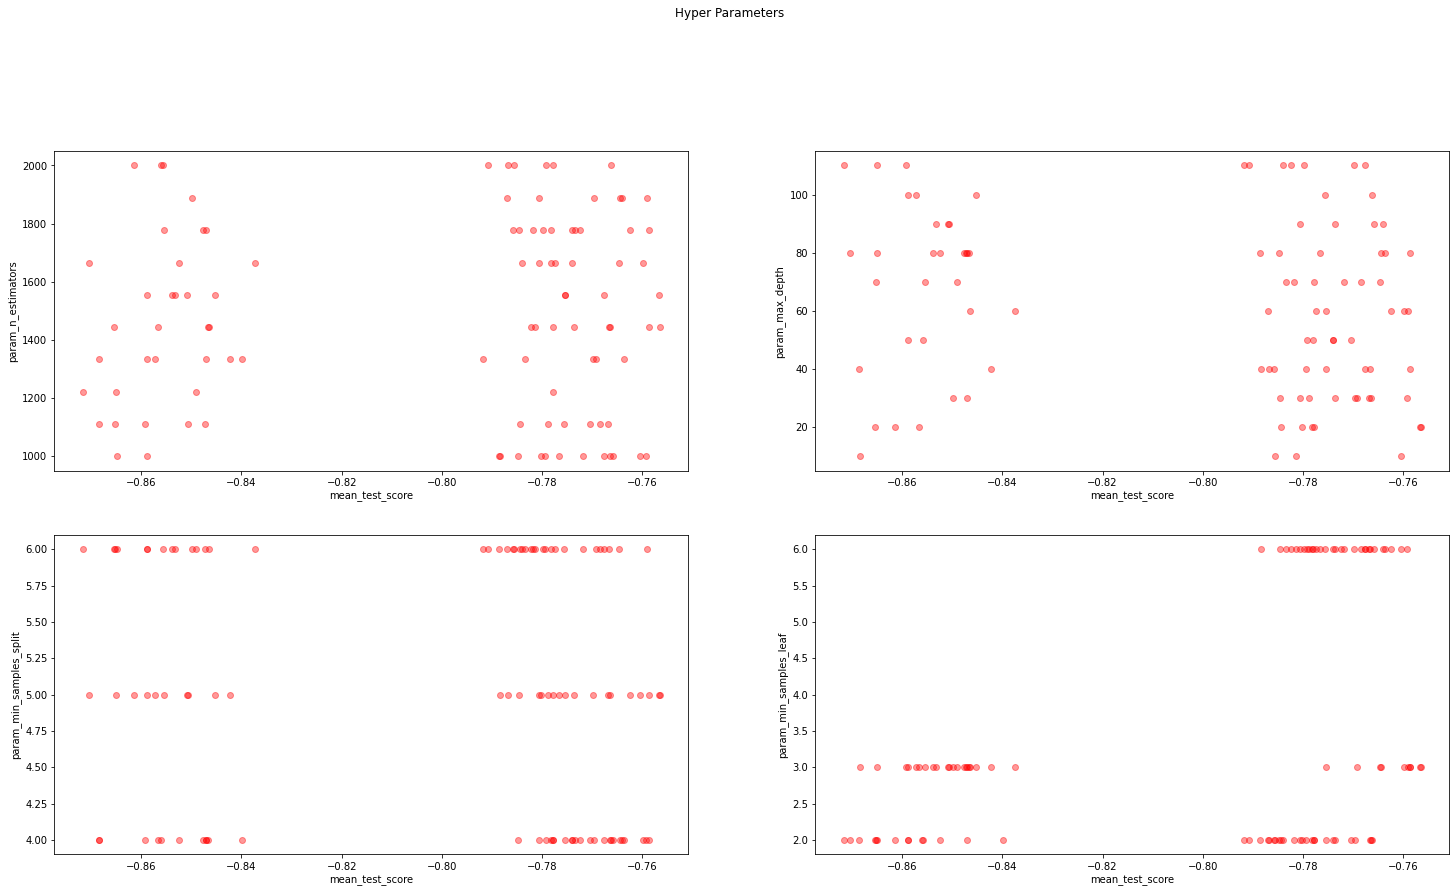

In [27]:
# Plot the hyper-parameters in relation of mean test score
# Values are plotted through dots. The brighter the dot, the more times that value has been chosen by the models.
# On the X axis, the closer the values are to 0 the better they are

h_params = ['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', ]
fig = plt.figure(figsize=(25, 20))
fig.suptitle('Hyper Parameters')
outer = gridspec.GridSpec(3, 2, wspace=0.2, hspace=0.2)
for index, h_param in enumerate(h_params):
    ax = plt.Subplot(fig, outer[index])
    ax.scatter(ris['mean_test_score'], ris[h_param], color='red', alpha=0.4, )
    ax.set_ylabel(h_param)
    ax.set_xlabel('mean_test_score')
    # ax.set_ylim(105, 110)
    fig.add_subplot(ax)
fig.show()

## Feature Importance

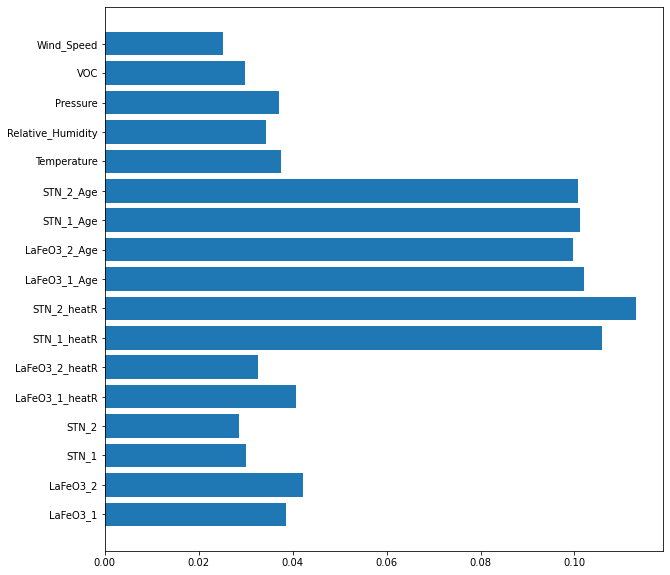

In [18]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.barh(X_test.columns, rf_random.best_estimator_.feature_importances_)
plt.show()

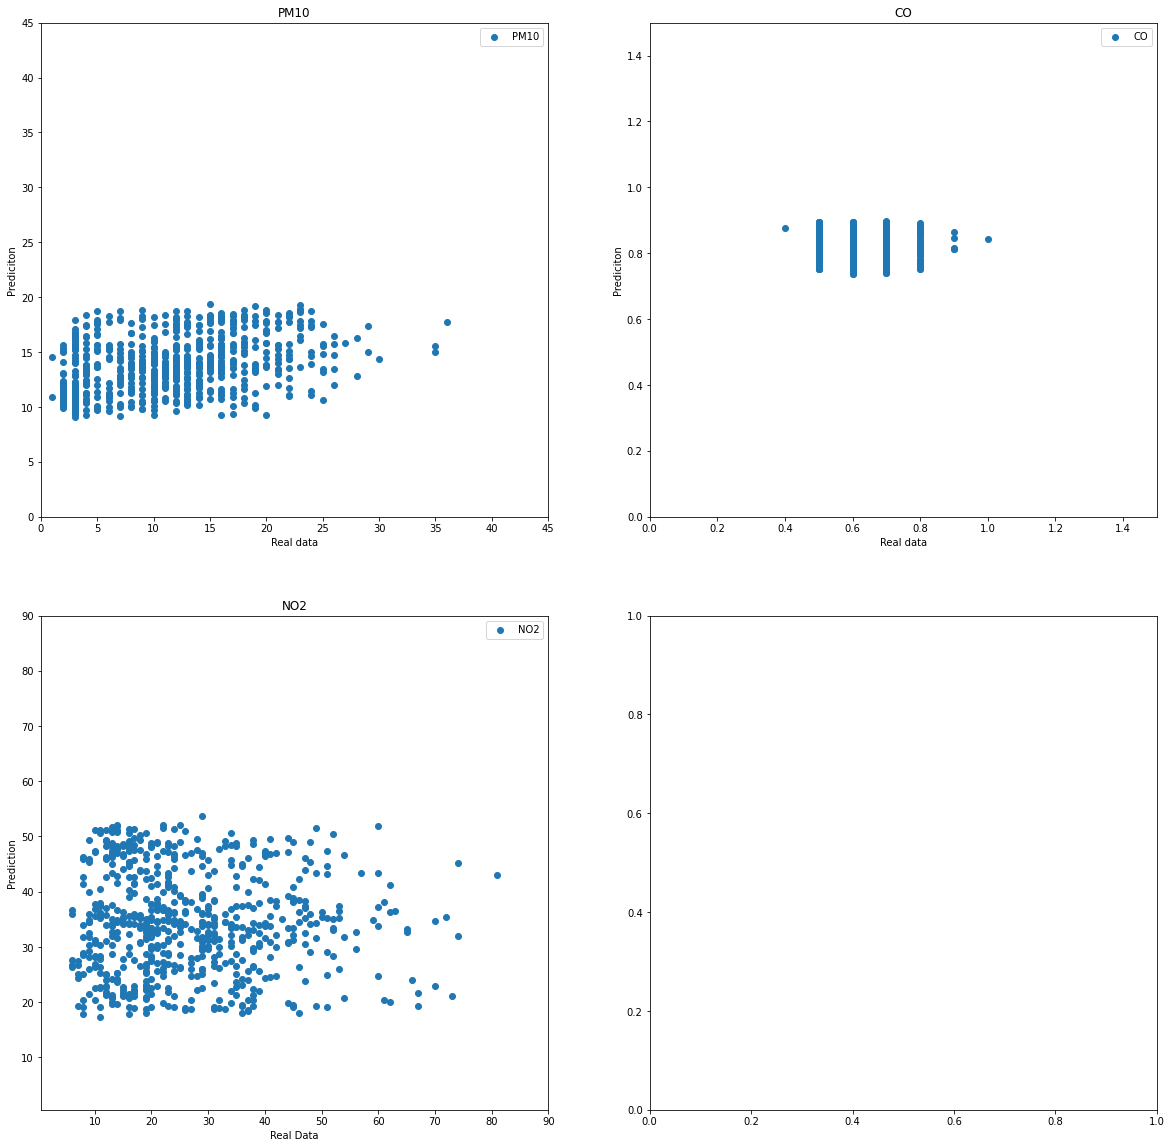

In [24]:
#Printing the charts to undersand better our predictions

fig,((ax1,ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

ax1.scatter(Y_test.PM10, rf_random.predict(X_test)[:, 0], label = "PM10")
ax2.scatter(Y_test.CO, rf_random.predict(X_test)[:, 1], label = "CO")
ax3.scatter(Y_test.NO2, rf_random.predict(X_test)[:, 2], label = "NO2")

ax1.set_xlim(0, 45)
ax1.set_ylim(0, 45)
ax2.set_xlim(0, 1.5)
ax2.set_ylim(0, 1.5)
ax3.set_xlim(0.5, 90)
ax3.set_ylim(0.5, 90)

ax1.set_title('PM10')
ax1.set_xlabel('Real data')
ax1.set_ylabel('Prediciton')
ax2.set_title('CO')
ax2.set_xlabel('Real data')
ax2.set_ylabel('Prediciton')
ax3.set_title('NO2')
ax3.set_xlabel('Real Data')
ax3.set_ylabel('Prediction')

ax1.legend()
ax2.legend()
ax3.legend()

plt.show()

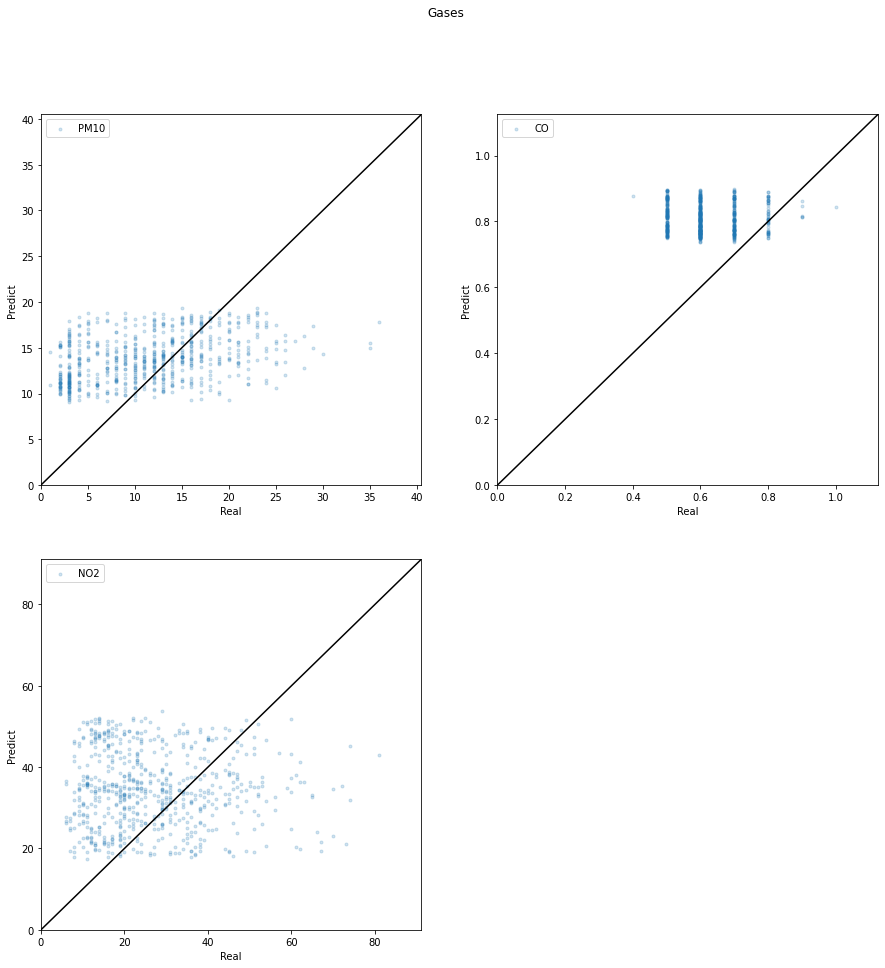

In [25]:
gases = Y_test.columns

fig = plt.figure(figsize=(15, 15))
fig.suptitle('Gases')
outer = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.2)
for index, gas in enumerate(gases):
    ax = plt.Subplot(fig, outer[index])
    ax.scatter(Y_test[gas], rf_random.predict(X_test)[:,index], marker=".", alpha=0.2, label=gas)
    ax.set_xlabel(f"Real")
    ax.set_ylabel(f"Predict")
    ax.set_xlim(0, Y_test[gas].max()*9/8)
    ax.set_ylim(0, Y_test[gas].max()*9/8)
    ax.plot([-100, Y_test[gas].max()*10], [-100,  Y_test[gas].max()*10], c="k", alpha=1)
    ax.legend()
    fig.add_subplot(ax)
fig.show()

In [34]:
appa2.CO.describe()

count    3239.000000
mean        0.724359
std         0.228097
min         0.300000
25%         0.600000
50%         0.700000
75%         0.800000
max         2.600000
Name: CO, dtype: float64

In [35]:
appa2.CO.value_counts()

0.6    735
0.5    584
0.8    536
0.7    417
0.9    399
1.0    171
0.4    152
1.1    112
1.2     45
1.3     28
1.4     21
1.5      8
1.7      7
0.3      7
1.9      5
1.6      4
1.8      3
2.0      2
2.4      1
2.6      1
2.3      1
Name: CO, dtype: int64

In [36]:
Y_train.CO.value_counts()

0.6    584
0.5    471
0.8    427
0.7    332
0.9    320
1.0    143
0.4    127
1.1     87
1.2     33
1.3     21
1.4     16
1.5      7
0.3      6
1.7      4
1.9      4
1.6      3
1.8      2
2.6      1
2.4      1
2.3      1
2.0      1
Name: CO, dtype: int64